# Notebook for results visualization

In [1]:
import numpy as np
import math, random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import pandas as pd
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
# Use CUDA
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


import gym
env = gym.make('LunarLander-v2')

In [2]:
discr_vector = (8,8,8,8,8,8,2,2)   # Resolution degrees: How many discrete states per variable. Play with this parameter!

class Discretizer ():
    """ mins: vector with minimim values allowed for each variable
        maxs: vector with maximum values allowed for each variable
    """
    def __init__(self, vector_discr, mins, maxs):
        self.mins=mins
        self.maxs=maxs
        
    def Discretize(self, obs):
        ratios = [(obs[i] + abs(self.mins[i])) / (self.maxs[i] - self.mins[i]) for i in range(len(obs))]
        new_obs = [int(round((discr_vector[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(discr_vector[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return tuple(new_obs)

In [3]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), requires_grad=False)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = env.action_space.sample()
        return action

In [4]:
import argparse
import gym
import os
import sys
from itertools import count

from torch.autograd import Variable
from torch.distributions import Categorical

import matplotlib.pyplot as plt
# plt.switch_backend('')

#import ipdb

# if gpu is to be used
use_cuda = torch.cuda.is_available()
#use_cuda = False
print("use_cuda : ", use_cuda)
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

class Actor(nn.Module):
    def __init__(self, state_size, num_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x),dim=-1)
        return x

class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 16)
        self.dp1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(16, 8)
        #self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dp1(x)
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

use_cuda :  False


In [5]:
import imageio
def generate_gif(images, PATH_IMAGES):
    frames_per_second = 64
    output_file = PATH_IMAGES + '/run.gif'
    imageio.mimsave(output_file, images, fps=frames_per_second)

In [6]:
def test_model(model, runs=5, render=True, return_frames=False, PATH_GIFS=None ):
    t=0
    tsteps=0
    treward=0
    rews = []
    frames = []
    locations = []
    env.close()
    for nexps in range(runs):   # Let's do 10 trials
        done= False  
        observation = env.reset() 
        locations.append(observation[:2])
        while not done:
            if PATH_GIFS or return_frames:
                frame = np.array(env.render(mode="rgb_array"))
                frames.append(frame)
                
            elif render:
                env.render()
            else:
                pass
            action = model.act(observation, 0)
            observation, reward, done, info = env.step(action) # take action from learned policy
#             print(observation[:2])
            locations.append(observation[:2])
            treward = treward + reward
            tsteps = tsteps + 1
            rews.append(reward)
            
    if PATH_GIFS:
#         for frame in frames:
#             plt.imshow(frame)
#             plt.savefig(PATH_GIFS+f'/tmp/{tsteps}.png')
        generate_gif(frames, PATH_GIFS)
    return frames, locations, rews

    print('Average reward',treward/10)
    print('Average time steps before ending episode',tsteps/10)

In [7]:
def moving_average(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [8]:
def save_model(model, PATH='model'):
    torch.save(model, PATH)

def load_model(PATH):
    return torch.load(PATH)

def save_arrays(matrix, PATH):
    np.savetxt(PATH, np.array(matrix) , fmt='%f')

def load_arrays(PATH):
    return np.loadtxt(PATH)

In [9]:
def get_rand_color():
    cols = np.array(list(mcolors.get_named_colors_mapping().values()))[:-9]
    c = np.random.choice(cols)
    return list(np.array(mcolors.hex2color(c))*255)

In [114]:
model = load_model('models/DQN/model1')

In [168]:
env.close()
test_model(model, PATH_GIFS=None)#'imgs/DQN')

Average reward 114.00204560152565
Average time steps before ending episode 105.7


In [7]:
import seaborn as sns

def plot_ts(data):
    res = []
    for arr in data:
        l = arr[:2000]
        for i, val in zip(range(len(l)), l):
            res.append([i,val])

    dataframe = pd.DataFrame(res)
#     dataframe.rename(columns={0:'iteration', 1:'reward'})
#     sns.tsplot(data)
    sns.lineplot(x=0, y=1, data=dataframe)
    plt.show()


# plot_ts(rews)
        

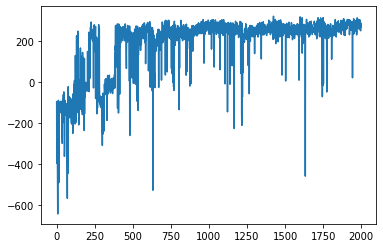

In [149]:
plt.plot(rews[0][:2000])

In [116]:
env.close()

# Q-Learning

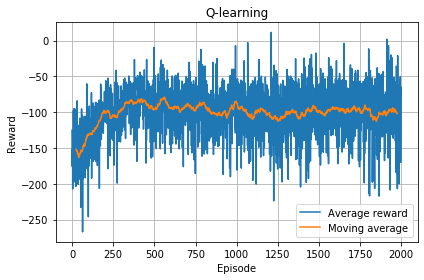

In [520]:
rews = []
M=2000
for i in range(5):
    a = load_arrays(f'results/Q-learning/rewards5_{i}.dat')
    rews.append(a[:M])
plt.plot(np.mean(rews, axis=0), label='Average reward')
N = 50
plt.plot(list(range(int(N/2),M-int(N/2)+1)), moving_average(np.mean(rews, axis=0),N), label='Moving average') 
plt.grid()
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Q-learning')
plt.tight_layout()
plt.savefig('results/Q-learning/ql-convergence.png',dpi=300)
plt.show()

In [189]:
with open('models/Q-learning/model4.npy', 'rb') as file:
    Q = np.load(file)
    
d = Discretizer(discr_vector, [-1,-1,-1,-1,-1,-1,0,0], [1,1,1,1,1,1,1,1])
def choose_action(state, epsilon):
    return env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(Q[state])
def rollout(epsilon, render=True):
    done = False
    gamma = 0.99
    R, reward = 0,0
    state = d.Discretize(env.reset())
    frames = []
    locations = []
    rews = []
    while done != True:
            if render: 
                frames.append(np.array(env.render(mode="rgb_array")))
            action = choose_action(state, epsilon) 
            obs, reward, done, info = env.step(action) 
            
            locations.append(obs[:2])
            R = gamma * R + reward
            state = d.Discretize(obs)
            rews.append(reward)
    return frames, locations, rews
frames = []
for _ in range(5):
    fs, locs, rs = rollout(0)
    frames += fs
env.close()

In [190]:
trews = []
for _ in range(100):
    fs, locs, rs = rollout(0, render=False)
    trews.append(sum(rs))
print(np.mean(trews))

-53.596079798637895


In [512]:
generate_gif(frames, PATH_IMAGES='imgs/Q-learning')

In [17]:
env.close()

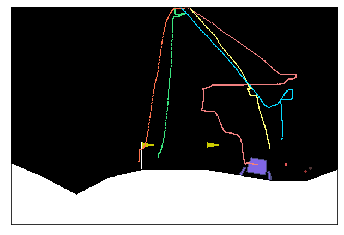

In [485]:
# f = fs[-1]

import matplotlib.colors as mcolors
c = get_rand_color()
for x, y in locs:
    i = max(0,int(275-y*200))
    j = int(300 + x*300)
    f[i:i+2,j:j+2,:] = c
plt.imshow(f)
plt.xticks([], [])
plt.yticks([], [])
# plt.show()
plt.savefig('results/Q-learning/dqn-5runs.png', dpi=300)

In [432]:
plt.savefig('results/Q-learning/q-5runs.png', dpi=300)

<Figure size 432x288 with 0 Axes>

# DQN

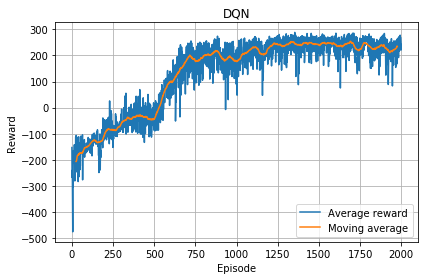

In [519]:
rews = []
for i in range(5):
    a = load_arrays(f'results/DQN/rewards5_{i}.dat')
    rews.append(a[:2000])
plt.plot(np.mean(rews, axis=0), label='Average reward')
N = 50
plt.plot(list(range(int(N/2),2000-int(N/2)+1)), moving_average(np.mean(rews, axis=0),N), label='Moving average')    
plt.grid()
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN')
plt.tight_layout()
plt.savefig('results/DQN/dqn-convergence.png',dpi=300)
plt.show()

In [37]:
model = load_model('models/DQN/model1')
env.close()
fs, locs, rs = test_model(model, runs=1, return_frames=True, PATH_GIFS=None)#'imgs/DQN')
env.close()

In [38]:
trews = []
for _ in range(100):
    fs, locs, rs = test_model(model, runs=1, render=False, return_frames=False, PATH_GIFS=None)
    trews.append(sum(rs))
print(np.mean(trews))

263.95462564116224


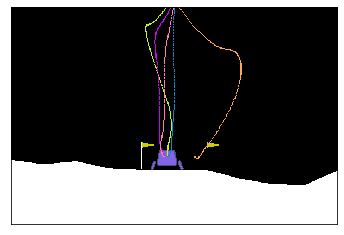

In [335]:
# f = fs[-1]
# f.shape
import matplotlib.colors as mcolors
c = get_rand_color()
for x, y in locs:
    i = max(0,int(275-y*200))
    j = int(300 + x*300)
    f[i:i+2,j:j+2,:] = c
plt.imshow(f)
# plt.axes().set_axes('off')
plt.xticks([], [])
plt.yticks([], [])
# plt.savefig('results/DQN/dqn-5runs.png', dpi=300)

# DDQN

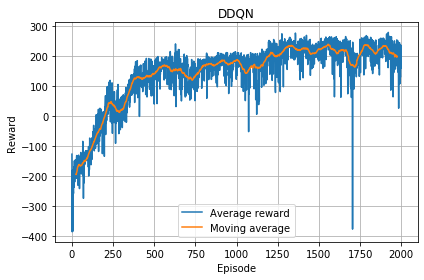

In [518]:
rews = []
for i in range(5):
#     if i == 1:continue
    a = load_arrays(f'results/DDQN/rewards5_{i}.dat')
    rews.append(a[:2000])
plt.plot(np.mean(rews, axis=0), label='Average reward')
N = 50
plt.plot(list(range(int(N/2),2000-int(N/2)+1)), moving_average(np.mean(rews, axis=0),N), label='Moving average') 
plt.grid()
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DDQN')
plt.tight_layout()
plt.savefig('results/DDQN/ddqn-convergence.png',dpi=300)
plt.show()

In [29]:
model = load_model('models/DDQN/model1')
env.close()
fs, locs,rs = test_model(model, runs=1, return_frames=True, PATH_GIFS=None)

In [32]:
trews = []
for _ in range(100):
    fs, locs, rs = test_model(model, runs=1, render=False, return_frames=False, PATH_GIFS=None)
    trews.append(sum(rs))
print(np.mean(trews))

235.05712859228984


In [30]:
env.close()

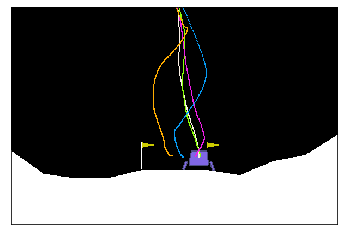

In [312]:
# f = fs[-1]
import matplotlib.colors as mcolors
c = get_rand_color()
for x, y in locs:
    i = max(0,int(275-y*200))
    j = int(300 + x*300)
    f[i:i+2,j:j+2,:] = c
plt.imshow(f)
# plt.axes().set_axes('off')
plt.xticks([], [])
plt.yticks([], [])
plt.savefig('results/DDQN/ddqn-5runs.png', dpi=300)

263.7358612829855

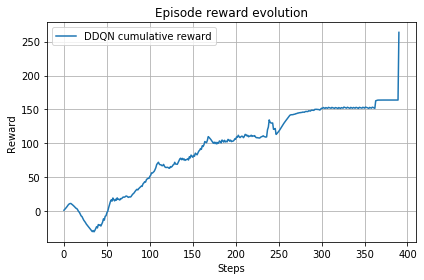

In [206]:
plt.plot(np.cumsum(rs), label='DDQN cumulative reward')
plt.grid()

plt.ylabel('Reward')
plt.xlabel('Steps')
plt.title('Episode reward evolution')
plt.legend()
plt.tight_layout()
plt.savefig('ddqn_cumsum.png', dpi=300)

sum(rs)

# A2C

In [10]:
actor = Actor(env.observation_space.shape[0], env.action_space.n)
actor.load_state_dict(torch.load('models/a2c/models_3/train_actor_ep_6000.pkl'))
# actor.load_state_dict(torch.load('models/a2c/train_actor_ep_2000.pkl'))
critic = Critic(env.observation_space.shape[0])
critic.load_state_dict(torch.load('models/a2c/models_3/train_critic_ep_6000.pkl'))
# critic.load_state_dict(torch.load('models/a2c/train_critic_ep_2000.pkl'))

def select_action(actor,critic, state):
    state = Variable(Tensor(state))
    log_probs = actor(state)
    value = critic(state)
    action = Categorical(log_probs.exp()).sample()
    return action.data.cpu().item()

In [12]:
tsteps=0
treward=0
frames = []
rews = []
trews = []
locations=[]
env.close()
PATH_GIFS=False
render=False
trews = []
for nexps in range(100):   # Let's do 10 trials
    done= False  
    observation = env.reset()
    t = 0
    while not done:# and t<500:
        if PATH_GIFS:
            frame = np.array(env.render(mode="rgb_array"))
            frames.append(frame)       
        elif render:
            env.render()
        else:
            pass
        action = select_action(actor, critic, observation)
#         action, _, _ = agent.select_action(observation)
        observation, reward, done, info = env.step(action) # take action from learned policy
        locations.append(observation[:2])
        treward = treward + reward
        tsteps = tsteps + 1
        rews.append(reward)
        t += 1
    trews.append(treward)
    
env.close()
print(treward)
print(np.mean(trews))

64.13656137636168
60.19465882335398


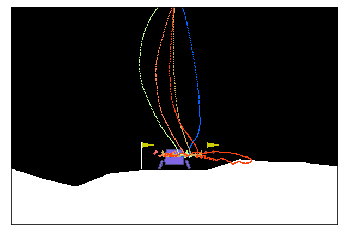

In [187]:
import matplotlib.colors as mcolors
c = get_rand_color()
for x, y in locations:
    i = max(0,int(275-y*200))
    j = int(300 + x*300)
    frame[i:i+2,j:j+2,:] = c
plt.imshow(frame)
# plt.axes().set_axes('off')
plt.xticks([], [])
plt.yticks([], [])
plt.savefig('results/a2c/a2c-5runs.png', dpi=300)

In [56]:
# generate_gif(frames, PATH_IMAGES='imgs/a2c')

-13.714936580415115

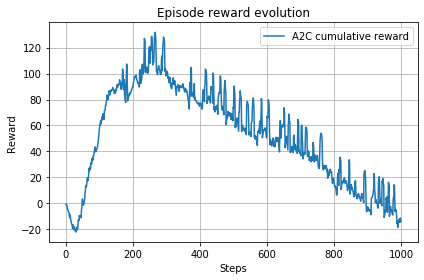

In [205]:
plt.plot(np.cumsum(rews), label='A2C cumulative reward')
plt.grid()
plt.tight_layout()
plt.ylabel('Reward')
plt.xlabel('Steps')
plt.title('Episode reward evolution')
plt.legend()
plt.tight_layout()
plt.savefig('a2c_rare_cumsum.png', dpi=300)

sum(rews)

In [11]:
env.close()

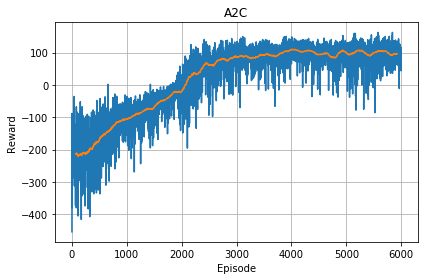

In [193]:
rews = []
M=6000
for i in range(1,4):
    a = load_arrays(f'results/a2c/rewards_{i}.dat')
    rews.append(a[:M])
plt.plot(np.mean(rews, axis=0), label='Average reward')
N = 150
plt.plot(list(range(int(N/2),M-int(N/2)+1)), moving_average(np.mean(rews, axis=0),N), label='Moving average') 
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('A2C')
plt.tight_layout()
plt.savefig('results/a2c/a2c-convergence.png',dpi=300)
plt.show()